In [26]:
import math
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from tqdm import tqdm
%matplotlib inline

In [27]:
INPUT_DIR = '../input'

In [30]:
from PIL import Image
import glob
"""
imgs = []
for filename in glob.glob('train/*.gif'): #assuming gif
    im=Image.open(filename)
    imgs.append(im)
    
"""

def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(f'{INPUT_DIR}/train/{filename}') for filename in filenames]
    
    return plot_images(imgs, labels, rows)

In [31]:
def plot_images(imgs, labels, rows=4):
    figure = plt.figure(figsize=(20, 10))
    
    cols = len(imgs) // rows + 1
    
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i+1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

In [32]:
np.random.seed(42)

In [33]:
train_df = pd.read_csv('train.csv')
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [34]:
train_df.shape

(25361, 2)

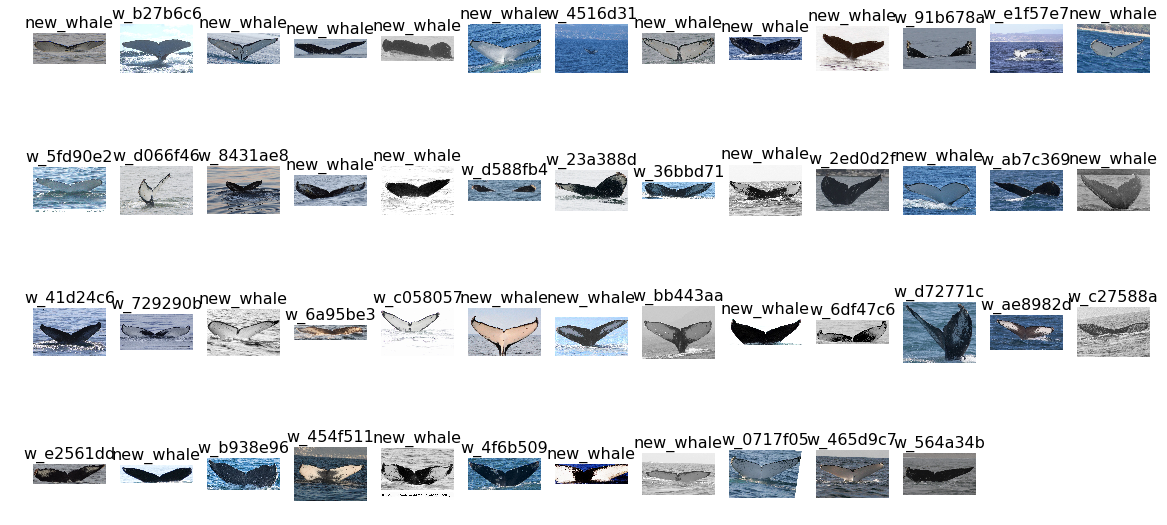

In [35]:
rand_rows = train_df.sample(frac=1.)[:50]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

In [36]:
print(len(imgs))

50


In [37]:
num_category = len(train_df['Id'].unique())
print(f'Number of categories: {num_category}')

Number of categories: 5005


In [38]:
size_buckets = Counter(train_df['Id'].value_counts().values)

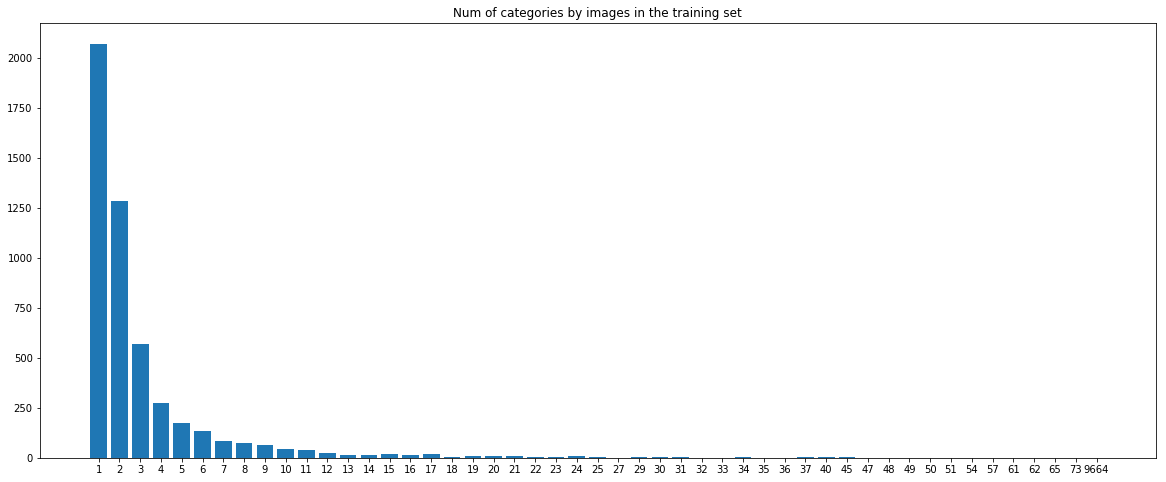

In [39]:
plt.figure(figsize=(20, 8))

plt.bar(range(len(size_buckets)), list(size_buckets.values())[::-1], align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys())[::-1])
plt.title("Num of categories by images in the training set")

plt.show()

In [43]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input


train_size = 1000
def prepareImages(train, shape, path):
    
    x_train = np.zeros((shape, 100, 100, 3))
    count = 0
    
    for fig in train.iloc[:train_size,0]:
        
        #load images into images of size 100x100x3
        img = image.load_img("../input/"+path+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        x_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    
    return x_train

In [44]:
x_train = prepareImages(train_df, train_size, "train")

Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  04c72257b.jpg


### Normalize the data

In [45]:
x_train = x_train / 255.0
print("x_train shape: ",x_train.shape)

x_train shape:  (1000, 100, 100, 3)


In [46]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [47]:
y_train = train_df.iloc[:train_size, 1]
# Drop 'Id' column
X_train = train_df.drop(labels = ["Id"], axis = 1)
y_train = label_encoder.fit_transform(y_train)

In [48]:
y_train.shape

(1000,)

In [49]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 5005)
y_train.shape
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [50]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential # to create a cnn model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [51]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (100,100,3)))
model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

# fully connected
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(y_train.shape[1], activation = "softmax"))

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
__________

In [53]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2 = 0.999)

In [54]:
# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='var_acc',
                                           patience = 3, 
                                           verbose = 1, 
                                           factor = 0.5,
                                           min_lr = 0.00001)

In [55]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

### Data augmentation

Epoch and Batch size

In [56]:
epochs = 10
batch_size = 1000

In [ ]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[learning_rate_reduction])

Epoch 1/10
